---
title: "Poster Visualizations"
format: 
  html:
    embed-resources: true
---

In [1]:
# imports 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

full_df = pd.read_csv("../data/clean/absenteeism_model_final.csv")

### Correlation Analysis

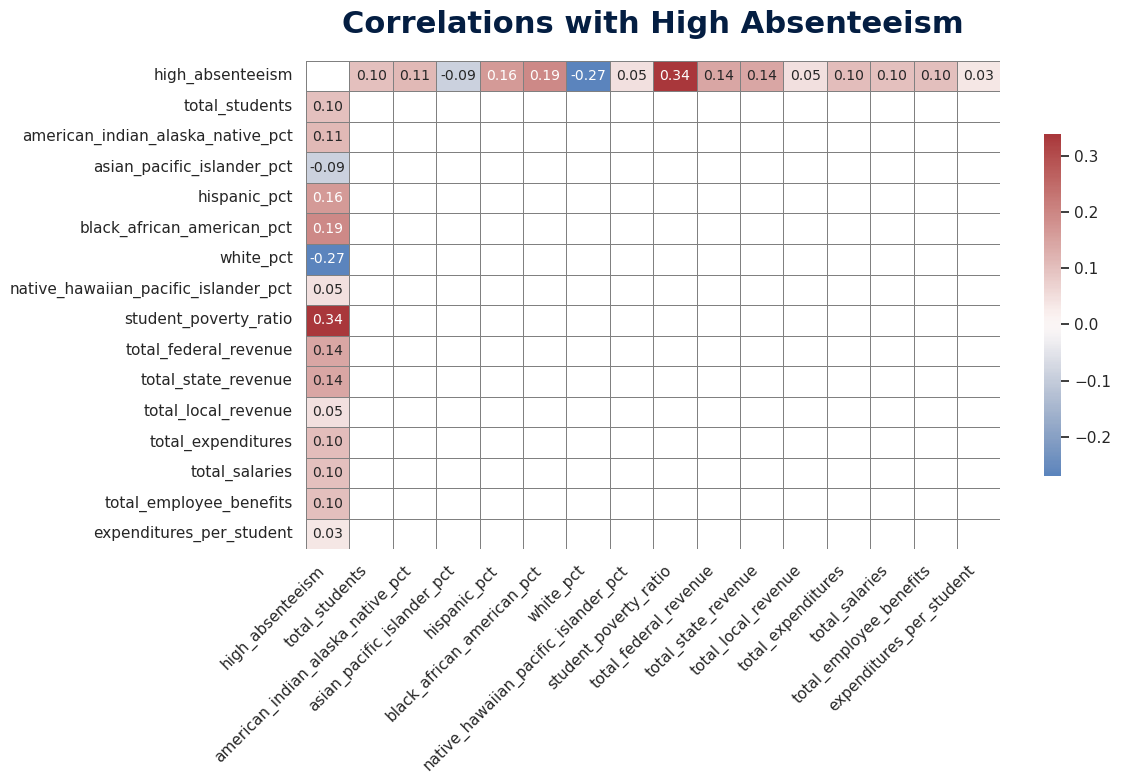

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Subset of columns to analyze
cols = [
    "high_absenteeism", "total_students",
    "american_indian_alaska_native_pct", "asian_pacific_islander_pct", "hispanic_pct",
    "black_african_american_pct", "white_pct", "native_hawaiian_pacific_islander_pct",
    "student_poverty_ratio",
    "total_federal_revenue", "total_state_revenue", "total_local_revenue",
    "total_expenditures", "total_salaries", "total_employee_benefits", "expenditures_per_student"
]

# Compute the correlation matrix for selected columns
corr = full_df[cols].corr()

# Mask everything except high_absenteeism correlations
mask = np.ones_like(corr, dtype=bool)
mask[:, cols.index("high_absenteeism")] = False  # keep the column
mask[cols.index("high_absenteeism"), :] = False  # keep the row
mask[cols.index("high_absenteeism"), cols.index("high_absenteeism")] = True  # hide self-correlation

# Plot heatmap
plt.figure(figsize=(12, 8))
sns.set_theme(style="white")

sns.heatmap(
    corr,
    mask=mask,
    cmap="vlag",
    center=0,
    annot=True,
    fmt=".2f",
    annot_kws={"fontsize": 10},
    linewidths=0.5,
    linecolor="gray",
    cbar_kws={"shrink": 0.7},
    square=False
)

# Titles and ticks
plt.title("Correlations with High Absenteeism", fontsize=22, fontweight="bold", color="#041E42", pad=20)
plt.xticks(rotation=45, ha='right', fontsize=11)
plt.yticks(fontsize=11)
plt.tight_layout()
plt.show()


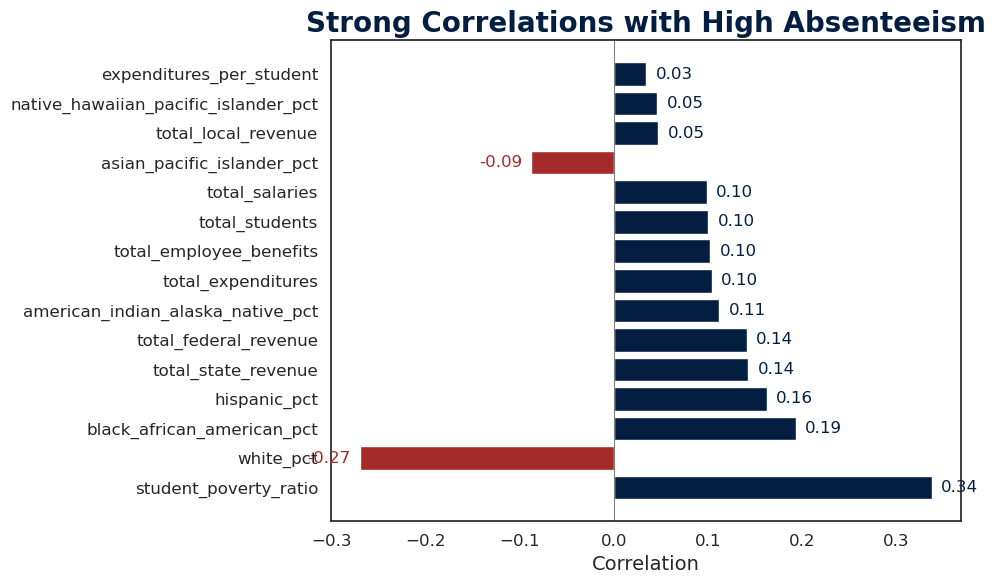

In [3]:
df = full_df.drop(columns=["high_absenteeism_doe", "absenteeism_class"])

# Compute correlations only with the target
target_corr = df.corr()["high_absenteeism"].drop("high_absenteeism")

# Sort by absolute correlation
sorted_corr = target_corr.reindex(target_corr.abs().sort_values(ascending=False).index)

# Set threshold for “important” correlation
threshold = 0.0
important_corr = sorted_corr[sorted_corr.abs() > threshold]

# Plot
sns.set_theme(style="white")
plt.figure(figsize=(10, 6))
bar_colors = ["#041E42" if val > 0 else "#A52A2A" for val in important_corr]  # dark blue vs dark red

bars = plt.barh(important_corr.index, important_corr.values, color=bar_colors)

# Add correlation value labels
for bar in bars:
    plt.text(bar.get_width() + 0.01 * np.sign(bar.get_width()),
             bar.get_y() + bar.get_height()/2,
             f"{bar.get_width():.2f}",
             va='center',
             ha='left' if bar.get_width() > 0 else 'right',
             fontsize=12,
             color=bar.get_facecolor())

# Styling
plt.title("Strong Correlations with High Absenteeism", fontsize=20, weight='bold', color="#041E42")
plt.xlabel("Correlation", fontsize=14)
plt.axvline(0, color='gray', linewidth=0.8)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()


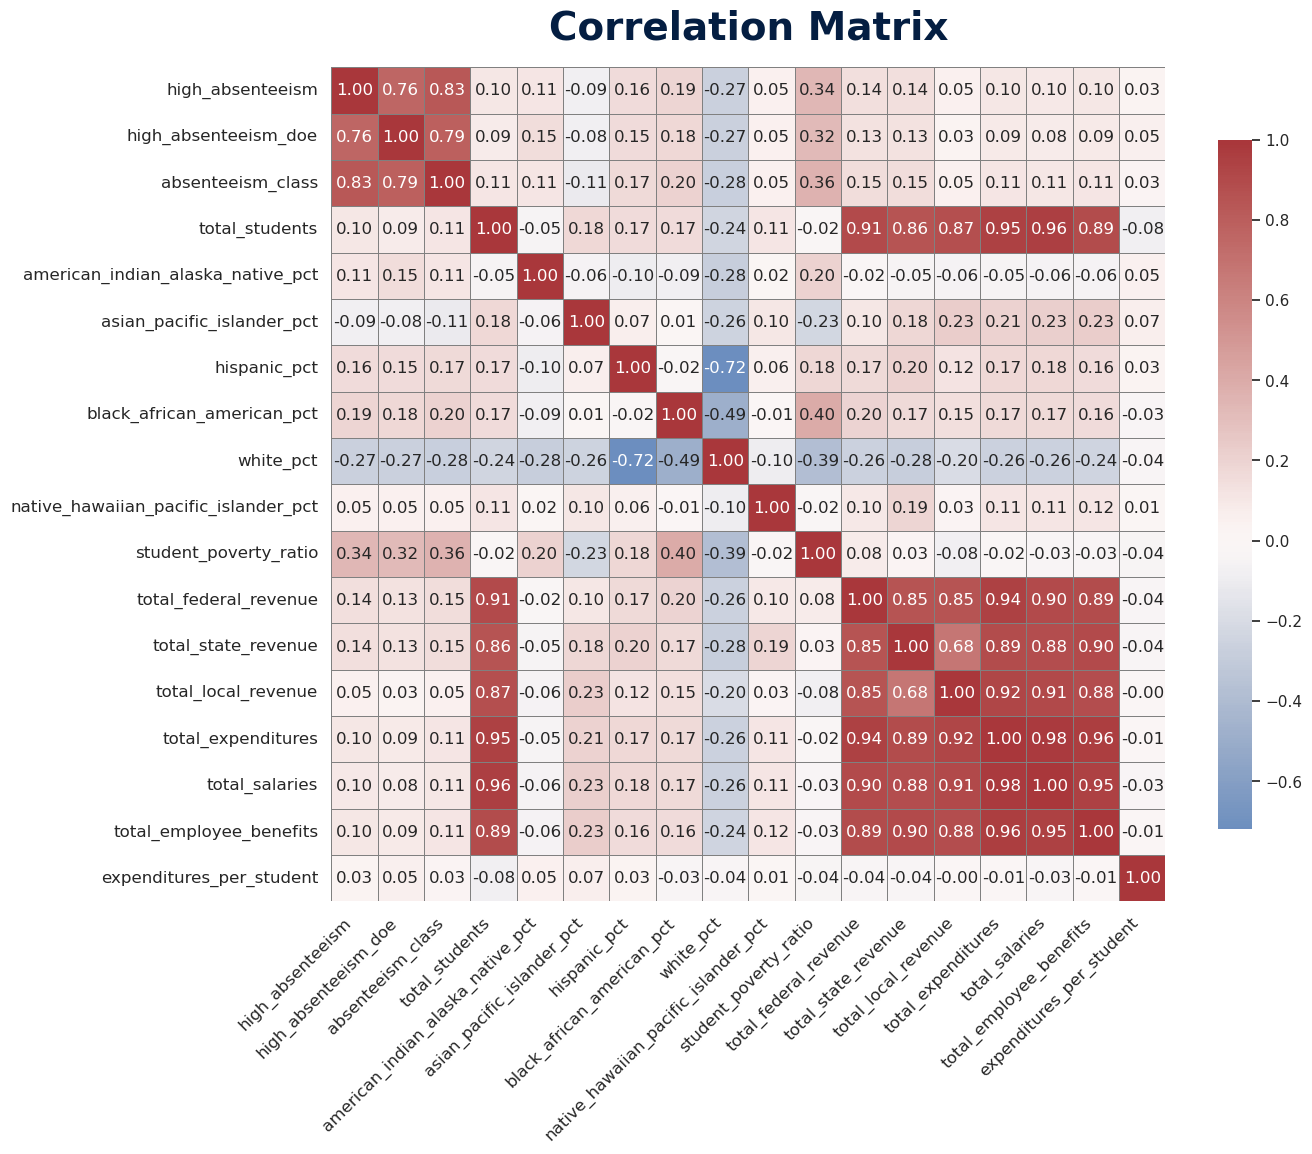

In [4]:
# Compute correlation matrix
corr_matrix = full_df.corr()

# Optional: Filter to subset of variables (e.g., numeric or top features)
# corr_matrix = corr_matrix.loc[top_features, top_features]  # if you defined those

# Set up the plot
plt.figure(figsize=(14, 12))
sns.set_theme(style="white")


# Create heatmap
ax = sns.heatmap(
    corr_matrix,
    cmap="vlag",  # or "RdBu_r" for diverging centered around 0
    center=0,
    annot=True,   # show correlation values
    fmt=".2f",
    linewidths=0.5,
    linecolor="gray",
    square=True,
    cbar_kws={"shrink": 0.75}
)

# Title and layout
plt.title("Correlation Matrix", fontsize=28, fontweight="bold", color="#041E42", pad=20)
plt.xticks(fontsize=12, rotation=45, ha='right')
plt.yticks(fontsize=12, rotation=0)
plt.tight_layout()
plt.show()


### Feature Importance

In [5]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

df1 = full_df.drop(columns=["high_absenteeism", "absenteeism_class", "high_absenteeism_doe", "total_students"])

X = df1
y = full_df["high_absenteeism"]

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.3, 
                                                    random_state=42)

clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

# Feature Importance
importances = clf.feature_importances_
indices = np.argsort(importances)[::-1]
features = X.columns

# Top N
top_n = 5
top_indices = indices[:top_n]
top_features = features[top_indices]
top_importances = importances[top_indices]

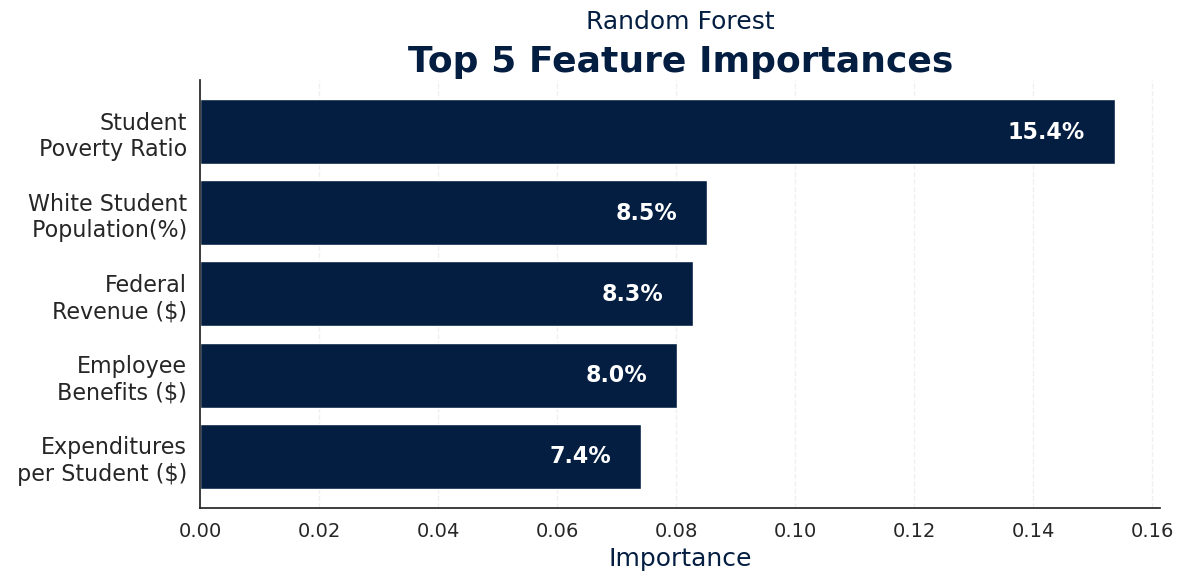

In [6]:
# Plot styling
dsan_blue = "#041E42"
sns.set_theme(style="white")
plt.figure(figsize=(12, 6))

# Reverse order for top-to-bottom
y_pos = np.arange(top_n)
bars = plt.barh(y_pos, top_importances, color=dsan_blue)

# Mapping for prettier feature names
feature_name_map = {
    "student_poverty_ratio": "Student\n Poverty Ratio",
    "white_pct": "White Student\n Population(%)", 
    "total_federal_revenue": "Federal\n Revenue ($)",
    "total_employee_benefits": "Employee\n Benefits ($)",
    "expenditures_per_student": "Expenditures\n per Student ($)"
}

# Apply mapping to top features
pretty_top_features = [feature_name_map.get(feat, feat) for feat in top_features]

# Y-axis: full feature names
plt.yticks(y_pos, pretty_top_features, fontsize=16)
plt.gca().invert_yaxis()  # Top-ranked at the top

# Importance score labels inside bars
for bar, importance in zip(bars, top_importances):
    plt.text(bar.get_width() - 0.005, bar.get_y() + bar.get_height()/2,
             f"{importance*100:.1f}%", va='center', ha='right', 
             fontsize=16, fontweight="bold", color="white")

# Title and axes
# plt.suptitle("Random Forest\nTop 5 Feature Importances", fontsize=26, fontweight='bold', color=dsan_blue)
plt.title("Top 5 Feature Importances", fontsize=26, fontweight='bold', color=dsan_blue)
plt.title("Random Forest", loc='left', x=0.5, y=1.1, ha='center', fontsize=18, color=dsan_blue)
plt.xlabel("Importance", fontsize=18, color=dsan_blue)
plt.xticks(fontsize=14)
plt.grid(axis='x', linestyle='--', alpha=0.3)

# Remove top and right spines
sns.despine(top=True, right=True)

plt.tight_layout()
plt.show()


## Confusion Matrices


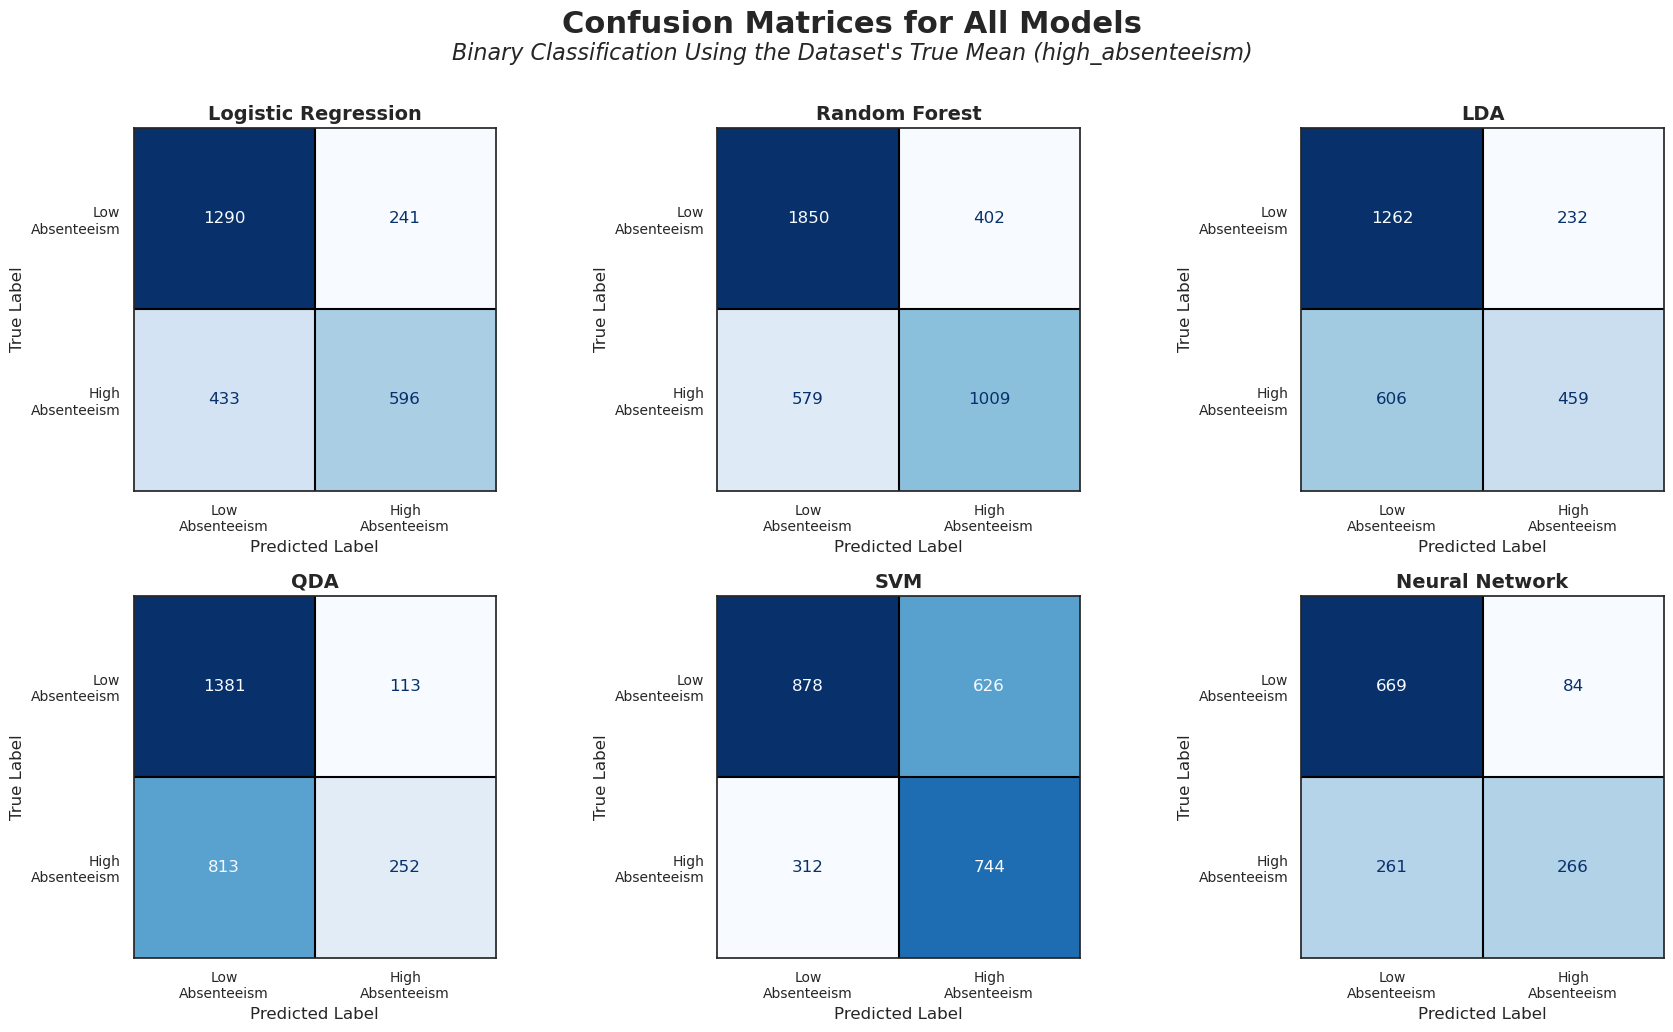

In [9]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
import numpy as np

# Actual confusion matrices, copied over for easier formatting
conf_matrices = [
    np.array([[1290, 241], [433, 596]]),
    np.array([[1850, 402], [579, 1009]]),
    np.array([[1262, 232], [606, 459]]),
    np.array([[1381, 113], [813, 252]]),
    np.array([[878, 626], [312, 744]]),
    np.array([[669, 84], [261, 266]])
]

model_names = [
    "Logistic Regression",
    "Random Forest",
    "LDA",
    "QDA",
    "SVM", 
    "Neural Network"   
]

class_labels = ["Low\nAbsenteeism", "High\nAbsenteeism"]

# Set up the plot grid
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.ravel()

for i in range(6):
    disp = ConfusionMatrixDisplay(
        confusion_matrix=conf_matrices[i],
        display_labels=class_labels
    )
    disp.plot(ax=axes[i], cmap="Blues", colorbar=False)
    # Add separating lines between the four cells
    axes[i].axhline(.5, color='black', lw=1.5)
    axes[i].axvline(.5, color='black', lw=1.5)
    # foramt titles
    axes[i].set_title(model_names[i], fontsize=14, fontweight="bold")
    axes[i].set_xlabel("Predicted Label", fontsize=12)
    axes[i].set_ylabel("True Label", fontsize=12)
    axes[i].tick_params(axis='both', labelsize=10)


# Add suptitle and subtitle using `fig.text`
fig.suptitle("Confusion Matrices for All Models", fontsize=22, fontweight="bold", y=1.03)
fig.text(0.5, .98, "Binary Classification Using the Dataset's True Mean (high_absenteeism)",
         ha='center', fontstyle='italic' , fontsize=16)

plt.tight_layout()
plt.show()